# Geodesignhub - Textual Classification

## Importing Packages and Data

Mounting onto google drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing packages:

Importing packages:

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import folium
import random


Importing the dataset:

In [ ]:
gdf = gpd.read_file("/content/drive/My Drive/Applying Data Science/Data/downloaded_data_polygons.gpkg", layer='polygons')
gdf.head()

,id,comment,category,date_added,geometry
0,1ec193a1-592b-4811-b572-1f09efc19ba0,Off leash dog walking path,🥾Pedestrian Use,2024-11-20T23:18:16.303653Z,"POLYGON ((-110.56601 45.67017, -110.56665 45.6..."
1,c6d095e9-509d-4959-ab84-133fc4e997da,Parking,🚗Parking,2024-11-17T19:47:01.111023Z,"POLYGON ((-110.56712 45.66994, -110.56738 45.6..."
2,1e5f34c1-8ac4-4ede-b88b-c6dacc6472bb,Parking,🚗Parking,2024-11-17T19:47:01.038581Z,"POLYGON ((-110.56712 45.66994, -110.56738 45.6..."
3,3ce1997e-d02d-40d7-9324-4f3be80f7c27,Exercise Apparatus Area,🛝Recreation Area,2024-11-17T19:46:03.573246Z,"POLYGON ((-110.56526 45.66998, -110.56589 45.6..."
4,5b85b07d-196d-40fe-b3cc-ae56b1033c5f,Gazebo/Covered Dining Area,🥾Pedestrian Use,2024-11-17T19:44:23.235577Z,"POLYGON ((-110.56508 45.67021, -110.56503 45.6..."


## 1. Exploratory Data Analysis

Missing data:

In [ ]:
print(f"The number of missing entries in the dataset: {gdf.isnull().sum().sum()}")

The number of missing entries in the dataset: 0


Summary statistics:

In [ ]:
print(f"The dataset contains {len(gdf)} responses.")
print("\nNumber of responses per category:")
print(gdf['category'].value_counts())
print("\nSummary statistics for response lengths:")
print(gdf['comment'].apply(len).describe())

The dataset contains 183 responses.

Number of responses per category:
category
🛝Recreation Area         46
🌳Planting                43
🥾Pedestrian Use          22
🚗Parking                 18
🚲Bike Use                16
🪧Wayfinding & Signage    15
🚻Restrooms               11
Fences & Barriers        10
🚰Water Services           2
Name: count, dtype: int64

Summary statistics for response lengths:
count    183.000000
mean      50.295082
std       68.147306
min        4.000000
25%       14.000000
50%       23.000000
75%       48.000000
max      374.000000
Name: comment, dtype: float64


Distribution of comment lengths:

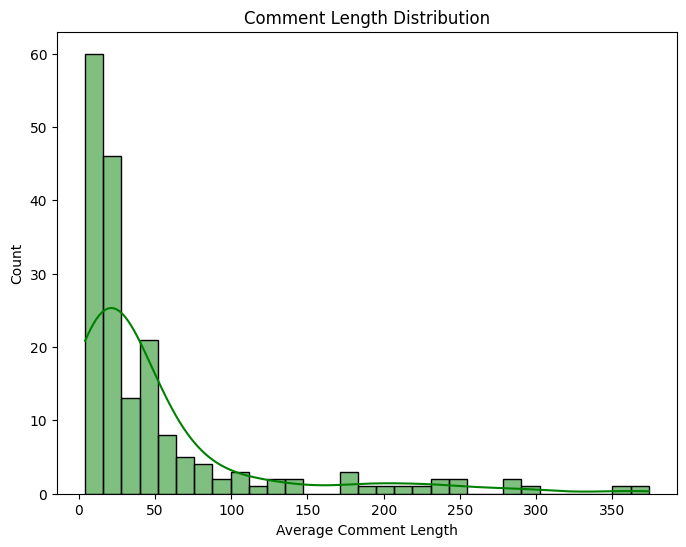

In [ ]:
gdf['comment_length'] = gdf['comment'].apply(lambda x: len(x))
plt.figure(figsize=(8, 6))
sns.histplot(gdf['comment_length'], kde=True, color='green')
plt.title('Comment Length Distribution')
plt.xlabel('Average Comment Length')
plt.show()

Words per comment:

In [ ]:
def word_count(text):
    words_list = text.split()
    return len(words_list)
gdf['word_count'] = gdf['comment'].apply(word_count)
print("Summary statistics for the number of words in each comment:")
print(gdf['word_count'].describe())

Summary statistics for the number of words in each comment:
count    183.000000
mean       8.076503
std       11.144143
min        1.000000
25%        2.000000
50%        4.000000
75%        7.000000
max       56.000000
Name: word_count, dtype: float64


In [ ]:
one_word_responses = gdf[gdf['word_count'] == 1]
print(f"Number of one-word responses: {len(one_word_responses)}")

Number of one-word responses: 14


Cleaning the textual data:

In [ ]:
def clean_text(text):
    text = text.lower()  # Lowercase all text
    text = text.replace("/", " ")  # Replace '/' with a space
    text = re.sub(r'[a-zA-Z0-9]+(?=\d)|(?<=\d)[a-zA-Z0-9]+', '', text)  # Remove alphanumeric codes like d1, e5, a9b
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.strip()  # Remove extra spaces
    return text
gdf['cleaned_comment'] = gdf['comment'].apply(clean_text)

Finding common words:

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt_tab')
gdf['tokens'] = gdf['cleaned_comment'].apply(nltk.word_tokenize)
all_tokens = [word for tokens in gdf['tokens'] for word in tokens]
all_tokens = [word for word in all_tokens if word not in stop_words]  # Remove stopwords
word_freq = Counter(all_tokens)
print("The ten most common words are:")
for word, freq in word_freq.most_common(10):
    print(f"{word}: {freq}")

The ten most common words are:
park: 39
area: 27
native: 24
trail: 18
parking: 17
shade: 16
play: 15
garden: 15
natural: 15
bike: 15


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Visualising word frequency:

<ipython-input-35-ddbfc9c9bf87>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')


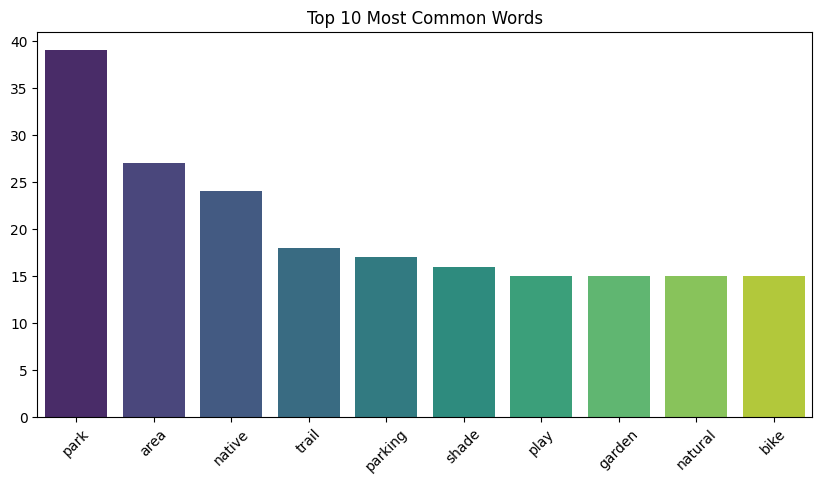

In [ ]:
top_words = word_freq.most_common(10)
words, counts = zip(*top_words)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(words), y=list(counts), palette='viridis')
plt.title('Top 10 Most Common Words')
plt.xticks(rotation=45)
plt.show()

Word cloud:

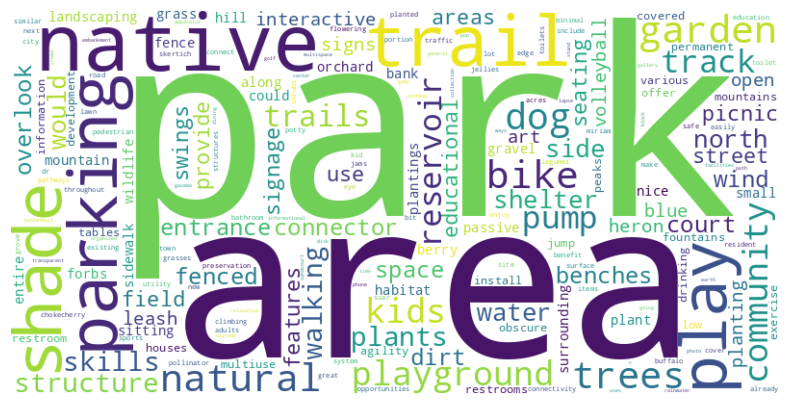

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Finding the most common bigrams:

<ipython-input-37-b85bd1684c15>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(bigrams), y=list(counts), palette='cubehelix')  # New color palette


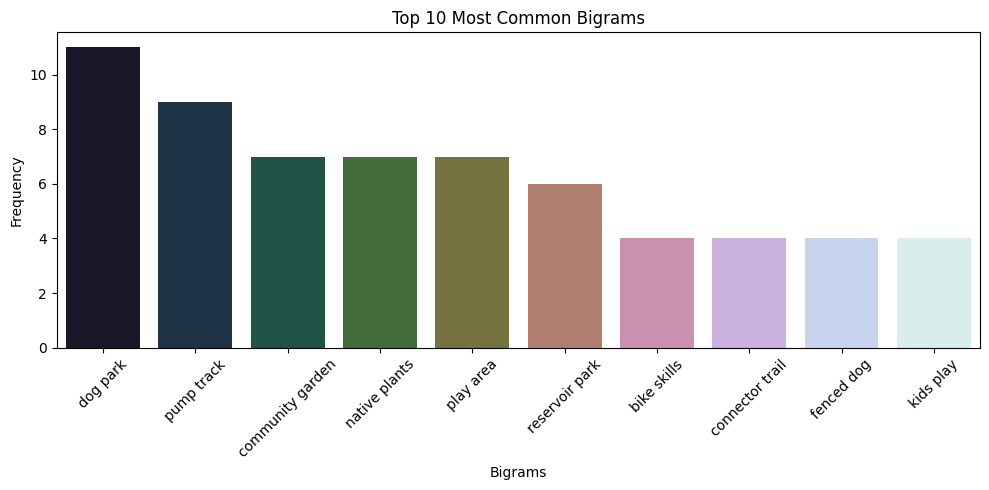

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=20)
bigrams = vectorizer.fit_transform(gdf['cleaned_comment'])

bigram_freq = dict(zip(vectorizer.get_feature_names_out(), bigrams.sum(axis=0).tolist()[0]))
bigram_freq = dict(sorted(bigram_freq.items(), key=lambda item: item[1], reverse=True))

top_bigrams = list(bigram_freq.items())[:10]
bigrams, counts = zip(*top_bigrams)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(bigrams), y=list(counts), palette='cubehelix')  # New color palette
plt.title('Top 10 Most Common Bigrams')
plt.xticks(rotation=45)
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
gdf = gdf.to_crs(epsg=4326)

center = [gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()]

m = folium.Map(location=center, zoom_start=13)

def style_function(feature):
    random_color = "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    return {
        'fillColor': random_color,
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7
    }

folium.GeoJson(gdf, style_function=style_function).add_to(m)
m

<ipython-input-38-17552e8bb67d>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()]
